<a href="https://colab.research.google.com/github/skotak2/Image-Captioning-With-Visual-Attention-Mechanism/blob/main/Code/Image_Captioning_Decoder_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q xlrd
!git clone https://github.com/skotak2/Image-Captioning-With-Visual-Attention-Mechanism/tree/main/Code



Cloning into 'Code'...
fatal: repository 'https://github.com/skotak2/Image-Captioning-With-Visual-Attention-Mechanism/tree/main/Code/' not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install keras

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/drive/MyDrive/Image_Captioning/Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Image_Captioning/captions.txt'

print("The number of jpg flies in Flicker8k: {}".format(len(images)))

The number of jpg flies in Flicker8k: 16211


In [ ]:
## read in the Flickr caption data
text = load_doc(descriptions_dir)
print(text[:330])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
10002


In [ ]:
def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [ ]:
df = make_dataset(text)

In [ ]:
data = pd.DataFrame(df,columns=["filename","index","caption"])
# Reordering columns for better readability
data = data.reindex(columns =['index','filename','caption'])

In [ ]:
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

In [ ]:
invalid_filename_check(data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [ ]:
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data.shape

(40455, 3)

In [ ]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print(ct_dict)

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [ ]:
unique_filenames = utility_counter(data)

The number of unique file names : 8091
We can see that all the keys are having values count = 5
Counter({'1000268201_693b08cb0e.jpg': 5, '1001773457_577c3a7d70.jpg': 5, '1002674143_1b742ab4b8.jpg': 5, '1003163366_44323f5815.jpg': 5, '1007129816_e794419615.jpg': 5, '1007320043_627395c3d8.jpg': 5, '1009434119_febe49276a.jpg': 5, '1012212859_01547e3f17.jpg': 5, '1015118661_980735411b.jpg': 5, '1015584366_dfcec3c85a.jpg': 5, '101654506_8eb26cfb60.jpg': 5, '101669240_b2d3e7f17b.jpg': 5, '1016887272_03199f49c4.jpg': 5, '1019077836_6fc9b15408.jpg': 5, '1019604187_d087bf9a5f.jpg': 5, '1020651753_06077ec457.jpg': 5, '1022454332_6af2c1449a.jpg': 5, '1022454428_b6b660a67b.jpg': 5, '1022975728_75515238d8.jpg': 5, '102351840_323e3de834.jpg': 5, '1024138940_f1fefbdce1.jpg': 5, '102455176_5f8ead62d5.jpg': 5, '1026685415_0431cbf574.jpg': 5, '1028205764_7e8df9a2ea.jpg': 5, '1030985833_b0902ea560.jpg': 5, '103106960_e8a41d64f8.jpg': 5, '103195344_5d2dc613a3.jpg': 5, '103205630_682ca7285b.jpg': 5, '10321

In [ ]:
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[20:25]:
      filename = image_dir + '/' + jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

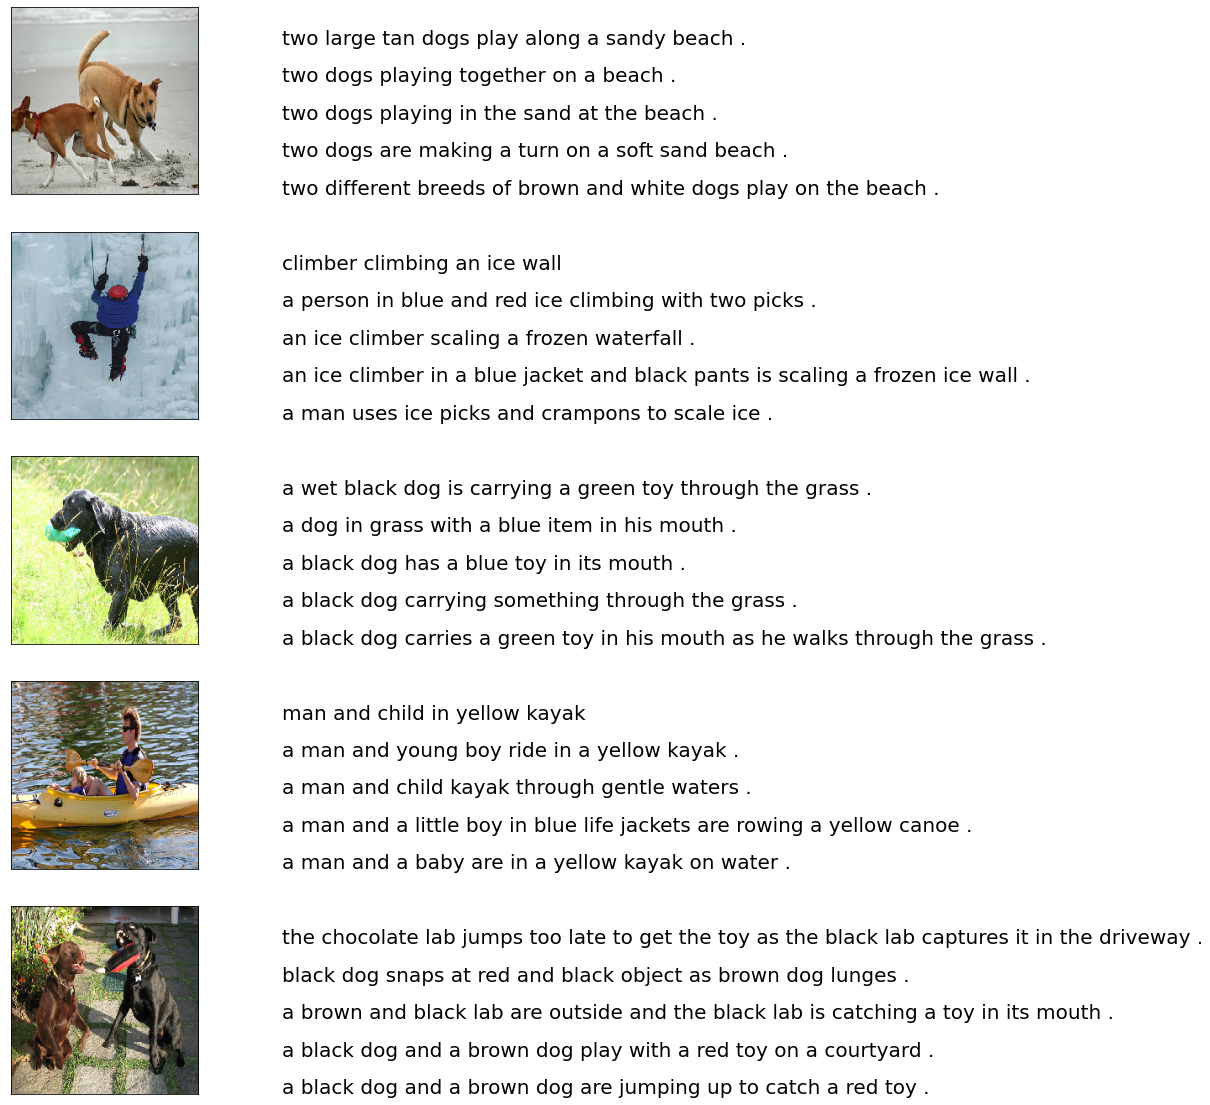

In [ ]:
image_desc_plotter(data)

In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

Vocabulary Size : 8918


In [ ]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [ ]:
dfwordcount = df_word_count(data,vocabulary)

In [ ]:
dfwordcount.iloc[:10,:]

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


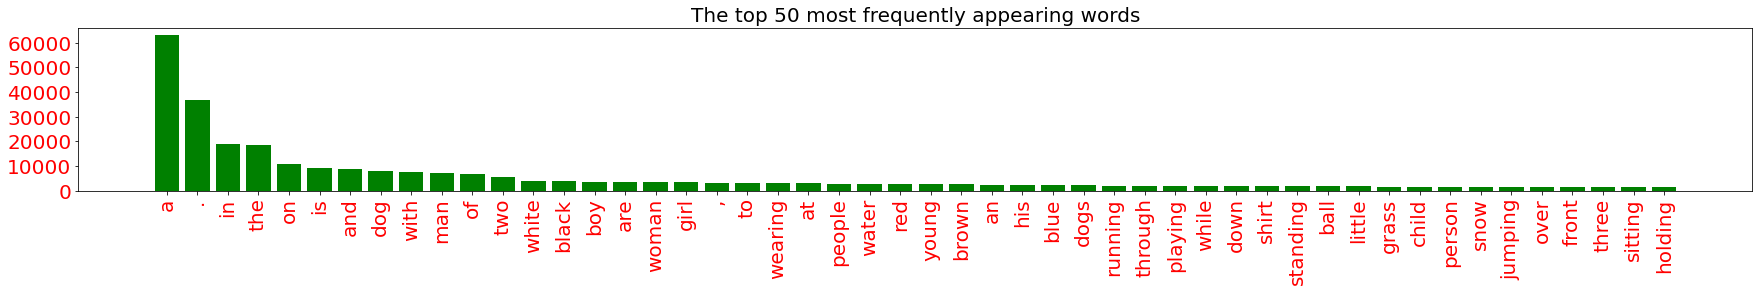

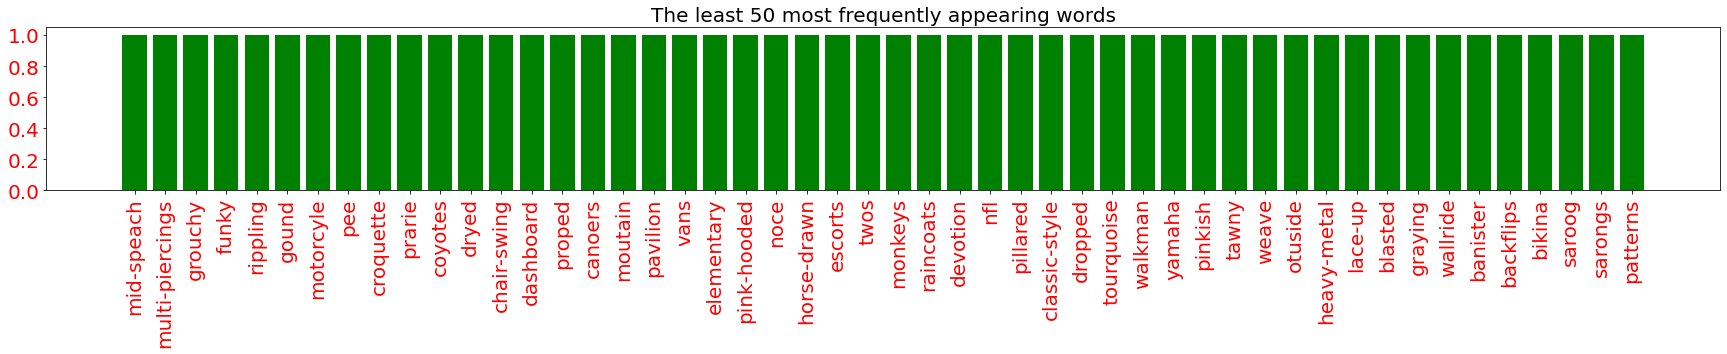

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = create_vocabulary(data)

Vocabulary Size : 8357


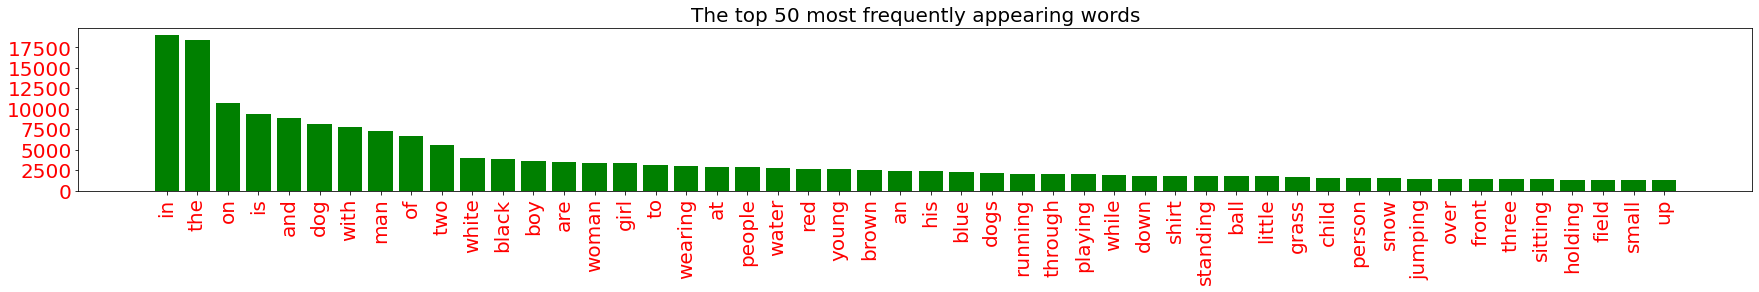

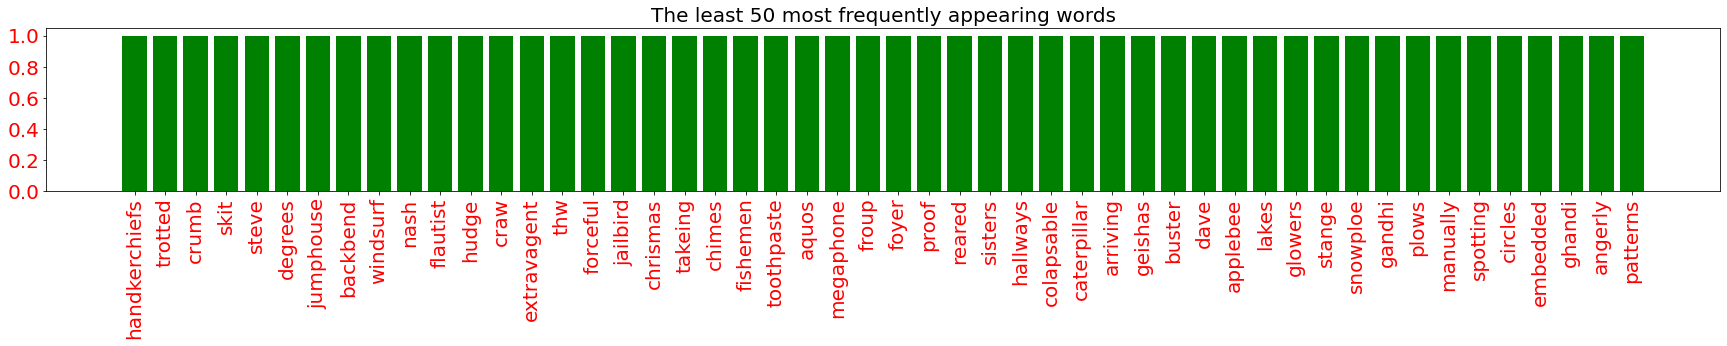

In [ ]:
dfwordcount = df_word_count(data,clean_vocabulary)
plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["filename"]:
      full_image_path = image_dir+"/"+ filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector
all_img_name_vector = preprocess_images(data)
all_img_name_vector[:10]

['/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg']

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
ten_images = all_img_name_vector[:50] # Each image repeats 5 times in dataset
unique_images = np.unique(ten_images)
print(unique_images)

['/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1002674143_1b742ab4b8.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1003163366_44323f5815.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1007129816_e794419615.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1007320043_627395c3d8.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1009434119_febe49276a.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1012212859_01547e3f17.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1015118661_980735411b.jpg'
 '/content/drive/MyDrive/Image_Captioning/Images/1015584366_dfcec3c85a.jpg']


In [ ]:

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

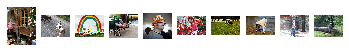

In [ ]:
showImagesHorizontally(unique_images)

In [ ]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [ ]:

print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [ ]:
from pickle import dump

# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [ ]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [ ]:

print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [ ]:
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[6],img.shape))

In [ ]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [ ]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> 1956678973_223cb1b847.jpg is ==> (500, 375, 3)
Shape of the image ==> 3256603992_67312b5a36.jpg is ==> (375, 500, 3)
Shape of the image ==> 2938747424_64e64784f0.jpg is ==> (375, 500, 3)
Shape of the image ==> 2831314869_5025300133.jpg is ==> (400, 500, 3)
Shape of the image ==> 516725192_c9cdd63878.jpg is ==> (274, 500, 3)
Shape of the image ==> 537559285_29be110134.jpg is ==> (375, 500, 3)
Shape of the image ==> 2172493537_128bc8b187.jpg is ==> (334, 500, 3)
Shape of the image ==> 2287023569_fd7a9c60b8.jpg is ==> (500, 354, 3)
Shape of the image ==> 3191805046_77c334b506.jpg is ==> (500, 333, 3)
Shape of the image ==> 2869491449_1041485a6b.jpg is ==> (350, 500, 3)
Shape of the image ==> 140377584_12bdbdf2f8.jpg is ==> (375, 500, 3)
Shape of the image ==> 132489044_3be606baf7.jpg is ==> (375, 500, 3)
Shape of the image ==> 2346401538_f5e8da66fc.jpg is ==> (322, 500, 3)
Shape of the image ==> 181157221_e12410ef0b.jpg is ==> (375, 500, 3)
Shape of the image ==> 31

Shape of the image:(500, 375, 3)


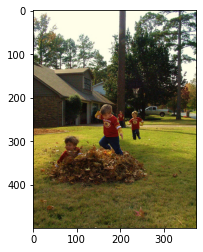

In [ ]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes("/content/drive/MyDrive/Image_Captioning/Images/1956678973_223cb1b847.jpg")

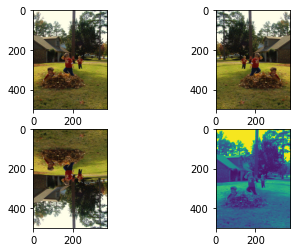

In [ ]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)

image_flipper("/content/drive/MyDrive/Image_Captioning/Images/1956678973_223cb1b847.jpg")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


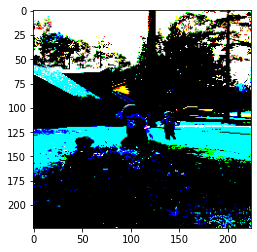

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image("/content/drive/MyDrive/Image_Captioning/Images/1956678973_223cb1b847.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

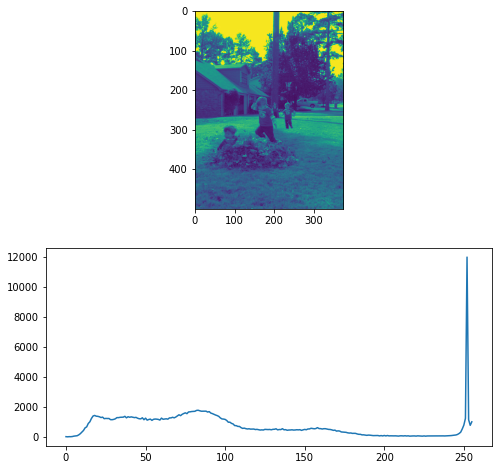

In [ ]:
# importing required libraries of opencv 
import cv2 
# importing library for plotting 
from matplotlib import pyplot as plt 
def plot_image_histograms(image): 
  # reads an input image 
  img = cv2.imread(image,0) 
  # find frequency of pixels in range 0-255 
  histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    
  # show the plotting graph of an image 
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr) 
  plt.show() 

plot_image_histograms("/content/drive/MyDrive/Image_Captioning/Images/1956678973_223cb1b847.jpg")

In [ ]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [ ]:
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['/content/drive/MyDrive/Image_Captioning/Images/1000268201_693b08cb0e.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1001773457_577c3a7d70.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1002674143_1b742ab4b8.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1003163366_44323f5815.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1007129816_e794419615.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1007320043_627395c3d8.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1009434119_febe49276a.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1012212859_01547e3f17.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1015118661_980735411b.jpg', '/content/drive/MyDrive/Image_Captioning/Images/1015584366_dfcec3c85a.jpg']


In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

In [ ]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
from tqdm import tqdm

In [ ]:
for img, path in tqdm(image_dataset):
   batch_features = image_features_extract_model(img)
   batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
   for bf, p in zip(batch_features, path):
     path_of_feature = p.numpy().decode("utf-8")
     np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [17:37<00:00,  8.33s/it]


In [ ]:
np_img =np.load('/content/drive/MyDrive/Image_Captioning/Images/997722733_0cb5439472.jpg.npy')

In [ ]:
print(np_img)
print("Shape : {}".format(np_img.shape))

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.90508693 ...  0.          0.76569194
  10.604531  ]
 [ 0.          0.         17.902946   ...  0.          0.
   7.7829943 ]
 [ 0.          0.         18.571892   ...  0.          0.
   0.        ]]
Shape : (49, 512)


In [ ]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [ ]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


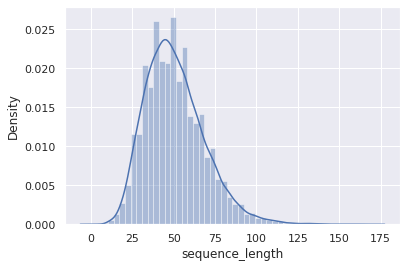

In [ ]:
import seaborn as sns

df=pd.DataFrame()
df["sequence_length"] = data["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

In [ ]:
  def padding_train_sequences(train_seqs,max_length,padding_type):
   cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
   return cap_vector

In [ ]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(40000, 33)


In [ ]:

padded_caption_vector

array([[  2, 184,  62, ...,   0,   0,   0],
       [  2,  11, 588, ...,   0,   0,   0],
       [  2,  14,   9, ...,   0,   0,   0],
       ...,
       [  2,  19,   4, ...,   0,   0,   0],
       [  2,  16,   4, ...,   0,   0,   0],
       [  2, 153,   9, ...,   0,   0,   0]], dtype=int32)

In [ ]:

# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [ ]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32000,Y = 32000
Test Data : X = 8000,Y = 8000


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
def create_dataset(img_name_train,caption_train):

  
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:

# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49

In [ ]:
# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [ ]:
class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.gru = tf.keras.layers.GRU(self.units,
    #                               return_sequences=True,
    #                               return_state=True,
    #                               recurrent_initializer='glorot_uniform')
    self.gru = tf.keras.layers.LSTM(self.units,kernel_initializer="glorot_uniform",return_sequences=True,return_state=True)
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, c_state= self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
def call(self, x, features, hidden):
     
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state, c_state= self.gru(x)
    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2]))

    x= self.dropout(x)
    x= self.batchnormalization(x)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights


In [ ]:
''' Type: 'global' for Luong's Attention Mechanism(Global Attention) 
    Type: 'local' for Bahdanau's Attention Mechanism(Local Attention) 
'''
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply :local


In [ ]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
def Encoder_features(img_tensor, target):
   features = encoder(img_tensor)
   return features,target,img_tensor

for (batch, (img_tensor, target)) in enumerate(dataset):
  features,target,img_tensor= Encoder_features(img_tensor, target)

In [ ]:
target.shape # (batch_size,max_length)

TensorShape([64, 33])

In [ ]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 49, 512])

In [ ]:
features.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 49, 256])

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path_ckpt = "/content/drive/MyDrive/Image_Captioning/Check_Point/cp-{epoch:04d}.ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:

# Clear previous logs
!rm -rf ./logs/

In [ ]:

# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  #train_loss(loss)
  #train_accuracy(target, predictions)

  return loss, total_loss

In [ ]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [ ]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    
    if epoch % 5 == 0:
      ckpt_manager.save()


    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 5 TrainLoss 1.546781 TestLoss 0.499009
Time taken for 1 epoch 136.1321530342102 sec

Epoch 6 TrainLoss 1.148472 TestLoss 0.502289
Time taken for 1 epoch 86.67147207260132 sec

Epoch 7 TrainLoss 1.022828 TestLoss 0.504674
Time taken for 1 epoch 86.12899827957153 sec

Epoch 8 TrainLoss 0.937860 TestLoss 0.504683
Time taken for 1 epoch 85.53748917579651 sec

Epoch 9 TrainLoss 0.868682 TestLoss 0.512141
Time taken for 1 epoch 85.10695672035217 sec

Epoch 10 TrainLoss 0.808394 TestLoss 0.526675
Time taken for 1 epoch 85.59546685218811 sec

Epoch 11 TrainLoss 0.755032 TestLoss 0.538807
Time taken for 1 epoch 86.39628839492798 sec

Epoch 12 TrainLoss 0.706641 TestLoss 0.548242
Time taken for 1 epoch 86.58893609046936 sec

Epoch 13 TrainLoss 0.662726 TestLoss 0.567064
Time taken for 1 epoch 85.72201657295227 sec

Epoch 14 TrainLoss 0.623309 TestLoss 0.583992
Time taken for 1 epoch 86.29309153556824 sec

Epoch 15 TrainLoss 0.588403 TestLoss 0.607913
Time taken for 1 epoch 86.3579645156860

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

#rid = np.random.randint(0, len(img_name_test))
#image = img_name_test[rid]
image = '/content/drive/MyDrive/david.JPG'
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# result is in this format:  ['woman', 'plays', 'volleyball', '<end>']
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join
result_final = re.sub(r'^(<end>)', '', str(result_final))

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()


score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#print(f"BELU score: {score*100}")

#print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result_final, attention_plot)

#print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(image)
